In [4]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'SPR/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME
!pip3 install -U libsvm-official

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SPR
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from utils import *
from logistic_regression import *
import torchvision.datasets as dset
import torchvision.transforms as T
from logistic_regression import logistic_regression
import matplotlib.pyplot as plt
from MDA import *
import numpy as np

USE_GPU = False
dtype = torch.float32 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print_every = 100
print('using device:', device)

using device: cuda


In [3]:
#hyperparameters
NUM_TRAIN = 60000
NUM_VAL = 10000
NUM_TEST = 10000
LEARNING_RATE = 1e-9
BATCH_SIZE = 32
N_EPOCHS = 10
N_CLASSES = 10

In [6]:
# load and feed data to dataloader

transform = T.Compose([T.Resize((28, 28)),
                        T.ToTensor()])

mnist_train = dset.MNIST('./Datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(mnist_train, batch_size=NUM_TRAIN)

mnist_test = dset.MNIST('./Datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(mnist_test,  batch_size=NUM_TEST)

print("Loading the MNIST data complete")

Loading the MNIST data complete


In [7]:
X_train = loader_train.dataset.data.cpu().detach().numpy()
y_train = loader_train.dataset.targets.cpu().detach().numpy()
X_test = loader_test.dataset.data.cpu().detach().numpy()
y_test = loader_test.dataset.targets.cpu().detach().numpy()

X_train = flatten(X_train)
X_test = flatten(X_test)
print(X_train.shape)
X_train_PCA, V_train = PCA_proj(X_train)
X_test_PCA = np.real(np.matmul(X_test, V_train))
# print(X_train_PCA.shape)
# print(y_tra_PCA.shape)
# print(X_test.shape)
# print(y_test.shape)

X_train_MDA, Theta = MDA(X_train, y_train, N_CLASSES)
X_test_MDA = np.real(np.matmul(X_test, Theta))
# print(X_train_MDA.shape)
# print(y_train.shape)
# print(X_test_MDA.shape)
# print(y_test.shape)

(60000, 784)
---------------- Performing PCA on Data --------------------
60000 784
Covariance calculated
Required Dimension:  331
Got new clipped projection matrix
X_train projected


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


The non zero elements are  9


In [8]:
#encodes data 
y_train_enc = y_encoding(y_train, N_CLASSES)
y_test_enc = y_encoding(y_test, N_CLASSES)
print(y_train_enc.shape)
print(y_test_enc.shape)

(60000, 10)
(10000, 10)


In [13]:

def LR(X_train , y_train , X_test , y_test, y_train_enc, y_test_enc, LEARNING_RATE , N_EPOCHS):
  y_train_pred, train_losses, Theta  = logistic_regression(X_train, y_train_enc, LEARNING_RATE, N_EPOCHS)
  print(y_train_enc)
  print('Training Accuracy is : ', sum(y_train_pred == y_train)/ NUM_TRAIN*100)
  plt.plot(train_losses)
  plt.xlabel('Epochs')
  plt.ylabel('Training Loss')
  plt.title('Training Losses')
  plt.show()
  # Calculate Posteriors
  Phi = (np.exp(X_test.dot(Theta)) / np.sum(np.exp(X_test.dot(Theta)), axis=1).reshape(NUM_TEST,1))
  # Corr. Loss
  loss = -1*np.sum(y_test_enc * np.log(Phi))

  y_test_pred = np.argmax(Phi, axis = 1)
  print('Testing Loss: ', loss)
  print('Testing Accuracy: ', sum(y_test == y_test_pred)/NUM_TEST*100)

Number of training examples: 60000
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Training Accuracy is :  88.53


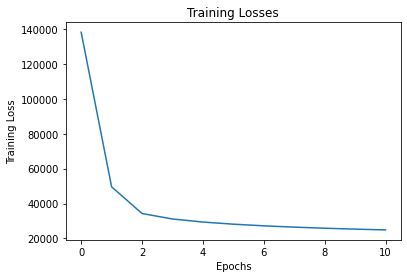

Testing Loss:  8588.06319372857
Testing Accuracy:  69.89


In [14]:
LR(X_train_PCA , y_train , X_test_PCA , y_test , y_train_enc, y_test_enc, LEARNING_RATE , N_EPOCHS)

Number of training examples: 60000
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Training Accuracy is :  78.84333333333333


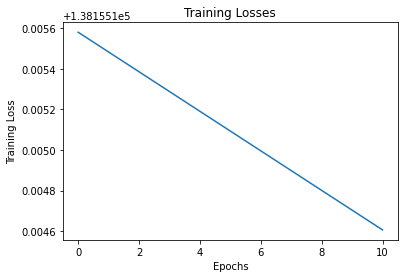

Testing Loss:  23025.850767049727
Testing Accuracy:  79.14999999999999


In [15]:
LR(X_train_MDA, y_train , X_test_MDA , y_test , y_train_enc, y_test_enc, LEARNING_RATE , N_EPOCHS)